<a href="https://colab.research.google.com/github/LucasBezerraSantos/Projetos_Pessoias/blob/master/Analise_de_credito_imobiliario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tipo de negócio:** Empresa Dream Housing Finance, a empresa lida com todos os empréstimos para habitação. Eles estão presentes em todas as áreas urbanas, semi-urbanas e rurais. O cliente aplica-se primeiro para um empréstimo à habitação depois que a empresa valida a elegibilidade do cliente para um empréstimo | Kaggle

**Problema:** A empresa deseja automatizar o processo de elegibilidade do empréstimo (em tempo real) com base nos detalhes do cliente fornecidos durante o preenchimento do formulário de inscrição on-line. Esses detalhes são sexo, estado civil, escolaridade, número de dependentes, renda, valor do empréstimo, histórico de crédito e outros. Para automatizar esse processo, eles criaram um problema para identificar os segmentos de clientes elegíveis para valores de empréstimo para atingir esses clientes especificamente.

# Modelagem

## Análise exploratória e transformação de dados

### Bibliotécas e Leitura dos Dados

In [2]:
from google.colab import drive
drive.mount('drive_content')

Mounted at drive_content


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
dados_imovel_train = pd.read_csv('/content/drive_content/MyDrive/Conjuntos_de_Dados/Kaggle/loan_sanction_train.csv')
dados_imovel_test = pd.read_csv('/content/drive_content/MyDrive/Conjuntos_de_Dados/Kaggle/loan_sanction_test.csv')

### Exploração de dados

In [5]:
dados_imovel_train.shape, dados_imovel_test.shape

((614, 13), (367, 12))

In [6]:
dados_imovel_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


### Transformação de dados

In [7]:
colunas_renomeadas = { "No": 0, "Yes": 1, "Male": 0, "Female": 1, "N": 0, "Y": 1, "Not Graduate": 0, "Graduate": 1, '3+': 3 }

In [8]:
dados_train_convert = dados_imovel_train[[ 'Gender', 'Married', 'Education', 'Self_Employed', 'Dependents', 'Loan_Status' ]].replace(colunas_renomeadas)
dados_imovel_train[['Rural',	'Semiurban',	'Urban']] = pd.get_dummies(dados_imovel_train.Property_Area)
dados_imovel_train.drop([ 'Loan_ID', 'Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status', 'Property_Area', 'Dependents' ], axis=1, inplace=True)

In [9]:
dados_imovel_num = pd.concat([dados_imovel_train, dados_train_convert], axis=1)

In [10]:
dados_imovel_num.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Rural,Semiurban,Urban,Gender,Married,Education,Self_Employed,Dependents,Loan_Status
0,5849,0.0,NaN,360.0,1.0,0,0,1,0.0,0.0,1,0.0,0,1
1,4583,1508.0,128.0,360.0,1.0,1,0,0,0.0,1.0,1,0.0,1,0
2,3000,0.0,66.0,360.0,1.0,0,0,1,0.0,1.0,1,1.0,0,1
3,2583,2358.0,120.0,360.0,1.0,0,0,1,0.0,1.0,0,0.0,0,1
4,6000,0.0,141.0,360.0,1.0,0,0,1,0.0,0.0,1,0.0,0,1


### Tratamento de dados nulos

In [11]:
dados_imovel_num.isnull().sum()

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Rural                 0
Semiurban             0
Urban                 0
Gender               13
Married               3
Education             0
Self_Employed        32
Dependents           15
Loan_Status           0
dtype: int64

**Dados em menor quantidade serão apagados**

In [12]:
drop_married = dados_imovel_num.loc[dados_imovel_num['Married'].isnull() == True]
dados_imovel_num.drop(drop_married.index, axis=0, inplace=True)

**As colunas que possuem dados vazios representam 0 e 1, "não" ou "sim", são dados categóricos e não contínuos. Por esse motivo é mais eficiênte usar a moda para preencher os dados nulos, com os dados que tem mais probalidade de ocorrer.**

In [13]:
for indice in range(len(dados_imovel_num.columns)):
  moda = int(dados_imovel_num[dados_imovel_num.columns[indice]].mode())
  dados_imovel_num[dados_imovel_num.columns[indice]] = dados_imovel_num[dados_imovel_num.columns[indice]].fillna(moda)

In [14]:
dados_imovel_num.isna().sum()

ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Rural                0
Semiurban            0
Urban                0
Gender               0
Married              0
Education            0
Self_Employed        0
Dependents           0
Loan_Status          0
dtype: int64

**Alterando dados float para int antes de usar a técnica de balanceamento SMOTE**

In [15]:
dados_imovel_num = dados_imovel_num.astype(int)
dados_imovel_num.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 611 entries, 0 to 613
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ApplicantIncome    611 non-null    int64
 1   CoapplicantIncome  611 non-null    int64
 2   LoanAmount         611 non-null    int64
 3   Loan_Amount_Term   611 non-null    int64
 4   Credit_History     611 non-null    int64
 5   Rural              611 non-null    int64
 6   Semiurban          611 non-null    int64
 7   Urban              611 non-null    int64
 8   Gender             611 non-null    int64
 9   Married            611 non-null    int64
 10  Education          611 non-null    int64
 11  Self_Employed      611 non-null    int64
 12  Dependents         611 non-null    int64
 13  Loan_Status        611 non-null    int64
dtypes: int64(14)
memory usage: 71.6 KB


### Balanceamento e Normalização

O balanceamento de dados é importante porque ajuda a evitar problemas de desequilíbrio de dados que podem afetar negativamente a precisão do algoritmo de Machine Learning. Portanto, é uma boa prática equilibrar os dados antes de rodar o algoritmo | ChatGPT

In [16]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [17]:
SEED = 3192
np.random.seed(SEED)

smote = SMOTE()
scaler = StandardScaler()

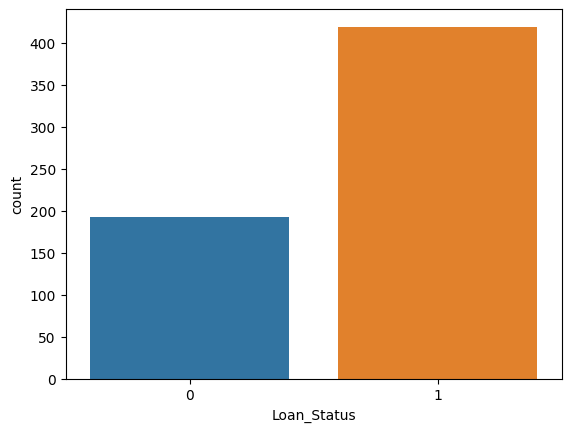

In [18]:
ax = sns.countplot(x='Loan_Status', data=dados_imovel_num)

In [19]:
X = dados_imovel_num.drop('Loan_Status', axis=1)
y = dados_imovel_num['Loan_Status']

X, y = smote.fit_resample(X, y)

In [20]:
dados_imovel_final = pd.concat([X, y], axis=1)

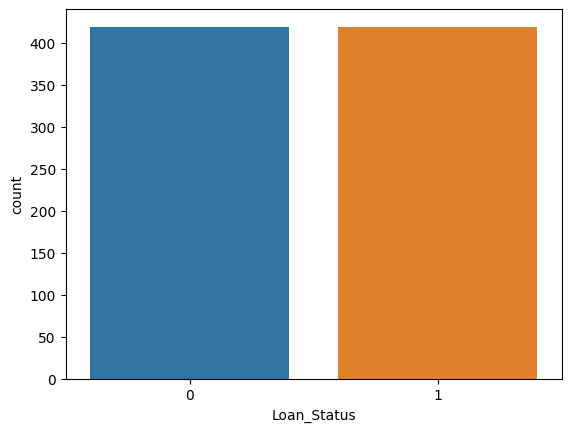

In [21]:
ax = sns.countplot(x= 'Loan_Status', data= dados_imovel_final)

In [22]:
dados_imovel_final.shape

(838, 14)

**Normalização**

In [23]:
X_normalizado = scaler.fit_transform(X)

## Aplicação do Modelo

In [24]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

In [25]:
X_train, X_test, y_train, y_test = train_test_split( X_normalizado, y, test_size=0.30, random_state= SEED, stratify= y )

### DummyClassifier

In [26]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
acuracia = dummy.score(X_test, y_test) * 100

print('A acurácia do Dummy foi de %d%%' % acuracia)

A acurácia do Dummy foi de 50%


### KNN

In [27]:
model_knn = KNeighborsClassifier(metric= 'euclidean')

model_knn.fit(X_train, y_train)
previsao_knn = model_knn.predict(X_test)

In [28]:
print('A Acurácia do KNN foi de %d%% \n' % (accuracy_score(y_test, previsao_knn)*100))
print('A Precisao do KNN foi de %d%% \n' % (precision_score(y_test, previsao_knn)*100))
print('O Reccal_score do KNN foi de %d%% \n' % (recall_score(y_test, previsao_knn)*100))
print('O F1-Score do KNN foi de %d%%' % (f1_score(y_test, previsao_knn)*100))

A Acurácia do KNN foi de 80% 

A Precisao do KNN foi de 74% 

O Reccal_score do KNN foi de 94% 

O F1-Score do KNN foi de 83%


**Matriz de confusão**

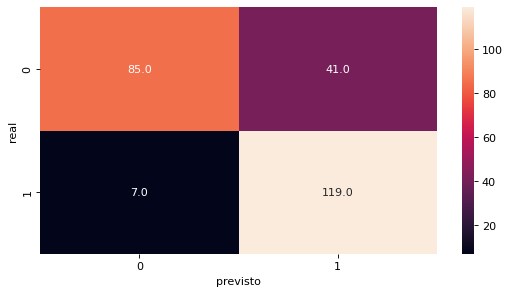

In [29]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_knn), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### Bernoulli

In [30]:
np.median(X_train)

-0.3425395354310701

In [31]:
model_bnb = BernoulliNB(binarize= 0.073)

model_bnb.fit(X_train, y_train)
previsao_bnb = model_bnb.predict(X_test)

In [32]:
print('A Acurácia do Bernoulli foi de %d%% \n' % (accuracy_score(y_test, previsao_bnb)*100))
print('A Precisao do Bernoulli foi de %d%% \n' % (precision_score(y_test, previsao_bnb)*100))
print('O Reccal_score do Bernoulli foi de %d%% \n' % (recall_score(y_test, previsao_bnb)*100))
print('O F1-Score do Bernoulli foi de %d%%' % (f1_score(y_test, previsao_bnb)*100))

A Acurácia do Bernoulli foi de 80% 

A Precisao do Bernoulli foi de 74% 

O Reccal_score do Bernoulli foi de 94% 

O F1-Score do Bernoulli foi de 83%


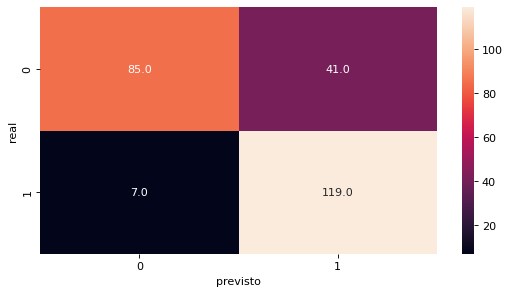

In [33]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_bnb), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### RandomForest

In [34]:
model_random = RandomForestClassifier( criterion= 'entropy', n_estimators=100, random_state=SEED )

model_random.fit(X_train, y_train)
previsao_random = model_random.predict(X_test)

In [35]:
print('A Acurácia do RandomForest foi de %d%% \n' % (accuracy_score(y_test, previsao_random)*100))
print('A Precisao do RandomForest foi de %d%% \n' % (precision_score(y_test, previsao_random)*100))
print('O Reccal_score do RandomForest foi de %d%% \n' % (recall_score(y_test, previsao_random)*100))
print('O F1-Score do RandomForest foi de %d%%' % (f1_score(y_test, previsao_random)*100))

A Acurácia do RandomForest foi de 84% 

A Precisao do RandomForest foi de 80% 

O Reccal_score do RandomForest foi de 92% 

O F1-Score do RandomForest foi de 85%


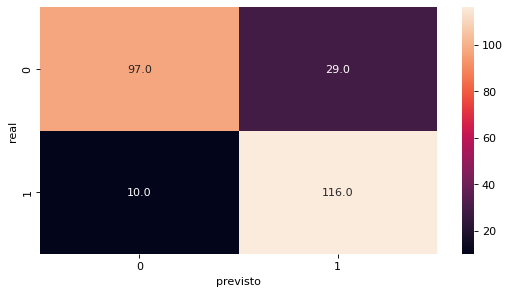

In [36]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_random), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### SVC

In [37]:
model_svc = SVC()

model_svc.fit(X_train, y_train)
previsao_svc = model_svc.predict(X_test)

In [38]:
print('A Acurácia do RandomForest foi de %d%% \n' % (accuracy_score(y_test, previsao_svc)*100))
print('A Precisao do RandomForest foi de %d%% \n' % (precision_score(y_test, previsao_svc)*100))
print('O Reccal_score do RandomForest foi de %d%% \n' % (recall_score(y_test, previsao_svc)*100))
print('O F1-Score do RandomForest foi de %d%%' % (f1_score(y_test, previsao_svc)*100))

A Acurácia do RandomForest foi de 84% 

A Precisao do RandomForest foi de 76% 

O Reccal_score do RandomForest foi de 99% 

O F1-Score do RandomForest foi de 86%


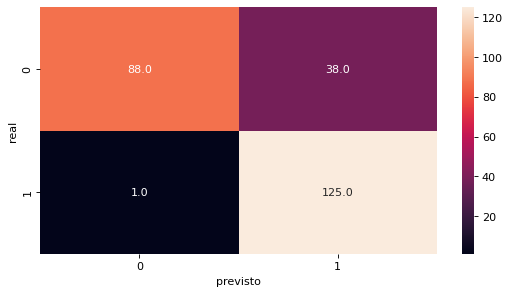

In [39]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_svc), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

## Aplicação com PCA

PCA (Principal Component Analysis) é uma técnica de redução de dimensionalidade que permite identificar os padrões subjacentes nos dados, removendo as correlações entre as variáveis e criando um conjunto menor de variáveis chamadas de componentes principais. A técnica funciona identificando os eixos que melhor explicam a variabilidade nos dados. | Chat GPT. 

O objetivo desta aplicação é reduzir a dimencionalidade e verificar se os modelos obtém melhores resultados. 

In [40]:
from sklearn.decomposition import PCA

In [41]:
pca = PCA( n_components = 10)
X_pca = pca.fit_transform(X_normalizado)

X_train, X_test, y_train, y_test = train_test_split( X_pca, y, test_size=0.30, random_state= SEED, stratify= y )

### KNN - PCA

In [42]:
model_knn = KNeighborsClassifier(metric= 'euclidean')

model_knn.fit(X_train, y_train)
previsao_knn = model_knn.predict(X_test)

In [43]:
print('A Acurácia do KNN foi de %d%% \n' % (accuracy_score(y_test, previsao_knn)*100))
print('A Precisao do KNN foi de %d%% \n' % (precision_score(y_test, previsao_knn)*100))
print('O Reccal_score do KNN foi de %d%% \n' % (recall_score(y_test, previsao_knn)*100))
print('O F1-Score do KNN foi de %d%%' % (f1_score(y_test, previsao_knn)*100))

A Acurácia do KNN foi de 81% 

A Precisao do KNN foi de 76% 

O Reccal_score do KNN foi de 92% 

O F1-Score do KNN foi de 83%


**Matriz de confusão**

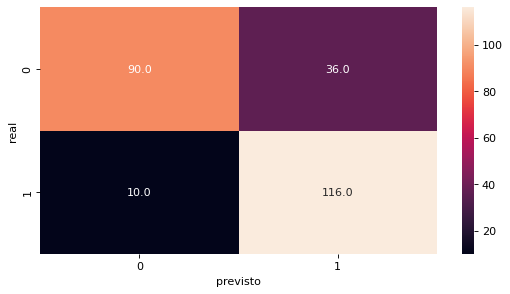

In [44]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_knn), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### Bernoulli - PCA

In [45]:
np.median(X_train)

-0.07372989556400375

In [46]:
model_bnb = BernoulliNB(binarize= 0.073)

model_bnb.fit(X_train, y_train)
previsao_bnb = model_bnb.predict(X_test)

In [47]:
print('A Acurácia do Bernoulli foi de %d%% \n' % (accuracy_score(y_test, previsao_bnb)*100))
print('A Precisao do Bernoulli foi de %d%% \n' % (precision_score(y_test, previsao_bnb)*100))
print('O Reccal_score do Bernoulli foi de %d%% \n' % (recall_score(y_test, previsao_bnb)*100))
print('O F1-Score do Bernoulli foi de %d%%' % (f1_score(y_test, previsao_bnb)*100))

A Acurácia do Bernoulli foi de 74% 

A Precisao do Bernoulli foi de 68% 

O Reccal_score do Bernoulli foi de 88% 

O F1-Score do Bernoulli foi de 77%


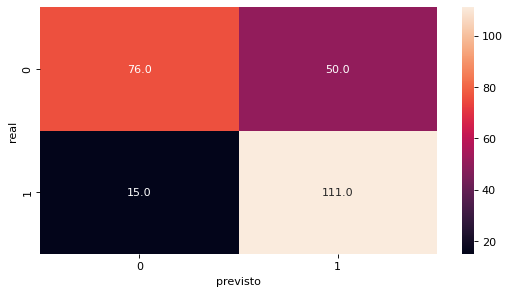

In [48]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_bnb), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### RandomForest - PCA

In [49]:
model_random = RandomForestClassifier( criterion= 'entropy', n_estimators=120, random_state=SEED )

model_random.fit(X_train, y_train)
previsao_random = model_random.predict(X_test)

In [50]:
print('A Acurácia do RandomForest foi de %d%% \n' % (accuracy_score(y_test, previsao_random)*100))
print('A Precisao do RandomForest foi de %d%% \n' % (precision_score(y_test, previsao_random)*100))
print('O Reccal_score do RandomForest foi de %d%% \n' % (recall_score(y_test, previsao_random)*100))
print('O F1-Score do RandomForest foi de %d%%' % (f1_score(y_test, previsao_random)*100))

A Acurácia do RandomForest foi de 83% 

A Precisao do RandomForest foi de 79% 

O Reccal_score do RandomForest foi de 90% 

O F1-Score do RandomForest foi de 84%


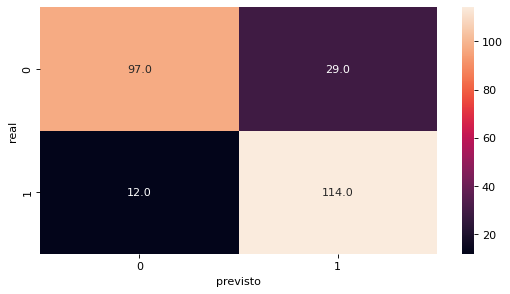

In [51]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_random), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### SVC - PCA

In [52]:
model_svc = SVC()

model_svc.fit(X_train, y_train)
previsao_svc = model_svc.predict(X_test)

In [53]:
print('A Acurácia do RandomForest foi de %d%% \n' % (accuracy_score(y_test, previsao_svc)*100))
print('A Precisao do RandomForest foi de %d%% \n' % (precision_score(y_test, previsao_svc)*100))
print('O Reccal_score do RandomForest foi de %d%% \n' % (recall_score(y_test, previsao_svc)*100))
print('O F1-Score do RandomForest foi de %d%%' % (f1_score(y_test, previsao_svc)*100))

A Acurácia do RandomForest foi de 84% 

A Precisao do RandomForest foi de 76% 

O Reccal_score do RandomForest foi de 99% 

O F1-Score do RandomForest foi de 86%


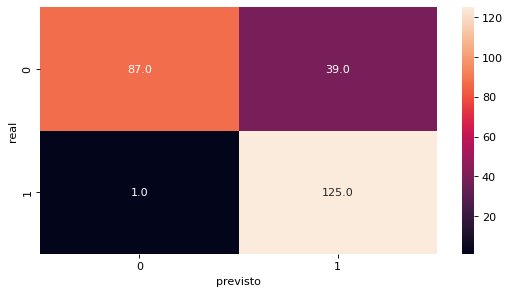

In [54]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_svc), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

# Otimização de Hiperparâmetros

Com os medelos anteriores conseguimos obter resultados significativos, entretanto não foram realizados testes para comprovar se eles são os melhores modelos possíveis, visto que não exploramos os hiperparametros. Também não foi utilizado o intervalo de confiança para avaliar as métricas, e por esse motivo a métrica não reflete a taxa de sucesso, caso o modelo fosse testado com dados novos.

Nesta etapa utilizaremos algumas técnicas para testar hiperparametros e chegar na combinação mais satisfatória para apresentação do modelo final. 

**As técnicas aplicadas com validação cruzada serão:**

Exploração manual;

GridSearchCV;

RandomizedSearchCV.



In [55]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_score

## RandomForest

### Análise Manual

Um das posibilidades de validação de hiperparametros é a análise manual. Podemos escolher diferentes hiperparametros e criar uma função que recebe essas instruções e devolve o resultado final, ordenando-os pelas melhores métricas. 

O ponto negativo é que o código não fica compacto e devido a limitações de procesamento as combinações podem ser limitadas.

In [56]:
def RandomForest_Hiperparametros( n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, class_weight ):
  
  #instancia o modelo
  #retorna uma lista com as métricas

  SEED = 3192
  np.random.seed(SEED)
  
  cv = KFold(n_splits = 10, shuffle=True)
  modelo = RandomForestClassifier( n_estimators= n_estimators, criterion= criterion, max_depth= max_depth, 
                                  min_samples_split= min_samples_split, min_samples_leaf= min_samples_leaf, 
                                  class_weight= class_weight)
  
  resultados = cross_validate(modelo, X_normalizado, y, cv = cv, return_train_score=True)

  train_score = resultados['train_score'].mean() * 100
  test_score = resultados['test_score'].mean() * 100

  tabela = [n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, class_weight, train_score, test_score]
  return tabela

In [57]:
# Aplicação

RandomForest_Hiperparametros( 100, 'gini', 5, 10, 20, 'balanced' )

[100, 'gini', 5, 10, 20, 'balanced', 83.06824529660794, 81.99655765920826]

In [58]:
# Aplicação com diferentes hiperparametros

lista = [ ]
for n_estimators in [50, 100]:
  for criterion in [ 'gini', 'entropy' ]:
    for max_depth in [3, 5 ]:
      for min_samples_split in [ 20, 30 ]:
        for min_samples_leaf in [ 10, 35 ]:
          for class_weight in [ 'balanced', None ]:
            tabela = RandomForest_Hiperparametros( n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, class_weight )
            lista.append( tabela )
    
resultados = pd.DataFrame(lista, columns= [ 'n_estimators', 'criterion', 'max_depth', 'min_samples_split', 
                                           'min_samples_leaf', 'class_weight' , "train", "test" ] )

resultados.sort_values('test', ascending=False).head()

,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,class_weight,train,test
60,100,entropy,5,30,10,balanced,84.049449,82.350832
44,100,gini,5,30,10,balanced,84.102605,81.992255
61,100,entropy,5,30,10,None,84.009661,81.992255
24,50,entropy,5,20,10,balanced,84.248283,81.871773
45,100,gini,5,30,10,None,83.969891,81.871773


**Testando o melhor modelo**

Rodamos o modelo no cross_validate quebrando os dados em 5 grupos diferentes e embaralhados para aferir a performance do resultado

In [59]:
modelo_hiper_RandomF = RandomForestClassifier( n_estimators= 100, criterion= 'entropy', max_depth= 5,
                                              min_samples_split= 30, min_samples_leaf= 10, class_weight= 'balanced')

Scores = cross_val_score( modelo_hiper_RandomF, X_normalizado, y, cv= KFold( n_splits=5, shuffle=True ))
Scores

array([0.80952381, 0.85119048, 0.80357143, 0.75449102, 0.81437126])

In [60]:
media = Scores.mean() * 100
desvio = Scores.std() * 100

print("Accuracy médio %.2f" % media)
print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Accuracy médio 80.66
Intervalo [74.48, 86.85]


### GridSearchCV

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [62]:
espaco_de_parametros = {
    "n_estimators" : [100],
    "criterion" : ['gini', 'entropy'],
    "max_depth" : [5, 7, 9],
    "min_samples_split" : [30, 40, 50],
    'min_samples_leaf': [10, 20],
    'class_weight': ['balanced', None]
}

SEED=3192
np.random.seed(SEED)

selecionador = GridSearchCV(RandomForestClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
selecionador.fit(X_normalizado, y)

resultados = pd.DataFrame(selecionador.cv_results_)
resultados.head(3).sort_values('rank_test_score', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.510858,0.165687,0.031919,0.004589,balanced,gini,5,10,40,100,"{'class_weight': 'balanced', 'criterion': 'gin...",0.851190,0.761905,0.839286,0.790419,0.862275,0.821015,0.038411,37
0,0.772449,0.318175,0.055781,0.038141,balanced,gini,5,10,30,100,"{'class_weight': 'balanced', 'criterion': 'gin...",0.845238,0.761905,0.815476,0.808383,0.868263,0.819853,0.036046,41
2,0.340356,0.116266,0.033205,0.018980,balanced,gini,5,10,50,100,"{'class_weight': 'balanced', 'criterion': 'gin...",0.833333,0.750000,0.815476,0.778443,0.856287,0.806708,0.038101,71


**Separa e embaralha os dados para medir a capacidade do algoritmo predizer as classes corretas**

*Devido ao alto custo computacional as linhas que realizam o cross_validate abaixo foram comentadas*

In [63]:
#Scores = cross_val_score( selecionador, X_normalizado, y, cv= KFold( n_splits=5, shuffle= True ) )
#Scores

In [64]:
# media = Scores.mean() * 100
# desvio = Scores.std() * 100

# print("Acurácia Média %.2f" % media)
# print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [65]:
# melhor = selecionador.best_estimator_
# melhor

### RandomizedSearchCV

*Com essa aplicação conseguimos testas diferentes parâmetros de forma aleatória, sem usar todo o grid, e com isso reduzimos o custo de processamento*

In [66]:
from scipy.stats import randint

In [67]:
espaco_de_parametros = {
    "n_estimators" : [100, 200],
    "criterion" : ['gini', 'entropy'],
    "max_depth" : randint(1, 20),
    "min_samples_split" : randint(1, 20),
    'min_samples_leaf': randint(1, 20),
    'class_weight': ['balanced', None]
}

SEED=3192
np.random.seed(SEED)

selecionador = RandomizedSearchCV( RandomForestClassifier(), espaco_de_parametros, n_iter= 5, cv= KFold( n_splits=5, shuffle=True ))
selecionador.fit( X_normalizado, y )
resultado = pd.DataFrame(selecionador.cv_results_)
resultado.head(3).sort_values('rank_test_score', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.345223,0.008586,0.023982,0.002412,balanced,gini,17,10,5,200,"{'class_weight': 'balanced', 'criterion': 'gin...",0.797619,0.833333,0.815476,0.832335,0.856287,0.827010,0.019608,2
2,0.157163,0.007465,0.010951,0.000428,balanced,entropy,1,1,8,100,"{'class_weight': 'balanced', 'criterion': 'ent...",0.791667,0.809524,0.785714,0.772455,0.772455,0.786363,0.013797,4
0,0.320941,0.012462,0.023117,0.001835,None,gini,2,1,5,200,"{'class_weight': None, 'criterion': 'gini', 'm...",0.797619,0.803571,0.773810,0.730539,0.784431,0.777994,0.025885,5


In [ ]:
Scores = cross_val_score( selecionador, X_normalizado, y, cv= KFold( n_splits=5, shuffle= True ) )
Scores

In [69]:
media = Scores.mean() * 100
desvio = Scores.std() * 100

print("Acurácia Média %.2f" % media)
print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Acurácia Média 83.17
Intervalo [80.13, 86.21]


In [70]:
selecionador.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 14,
 'n_estimators': 100}

## SVC

### Aplicação Manual

In [72]:
def SVC_Hiperparametros( c, kernel, shrinking, probability, class_weight ):
  
  #instancia o modelo
  #retorna uma lista com as métricas

  SEED = 3192
  np.random.seed(SEED)
  
  cv = KFold(n_splits = 10, shuffle=True)
  modelo = SVC( C= c, kernel= kernel, shrinking= shrinking, 
                probability= probability, class_weight= class_weight )
  
  resultados = cross_validate(modelo, X_normalizado, y, cv = cv, return_train_score=True)

  train_score = resultados['train_score'].mean() * 100
  test_score = resultados['test_score'].mean() * 100

  tabela = [ c, kernel, shrinking, probability, class_weight, train_score, test_score]
  return tabela

In [73]:
# Aplicação com diferentes hiperparametros

lista = [ ]
for c in [1, 1.5]:
  for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    for shrinking in [True, False]:
      for probability in [True, False]:
        for class_weight in ['balanced', None]:

          tabela = SVC_Hiperparametros( c= c, kernel= kernel, shrinking= shrinking, 
                probability= probability, class_weight= class_weight )
          lista.append( tabela )
    
resultados = pd.DataFrame(lista, columns= [ 'c', 'kernel', 'shrinking', 'probability', 'class_weight', "train", "test" ] )
resultados.sort_values('test', ascending=False).head()

,c,kernel,shrinking,probability,class_weight,train,test
23,1.0,rbf,False,False,None,86.064820,84.380379
16,1.0,rbf,True,True,balanced,86.078065,84.380379
22,1.0,rbf,False,False,balanced,86.078065,84.380379
21,1.0,rbf,False,True,None,86.064820,84.380379
20,1.0,rbf,False,True,balanced,86.078065,84.380379


In [74]:
modelo_hiper_SVC = SVC( C= 1, kernel= 'rbf', shrinking= False, 
                probability= False, class_weight= None )

Scores = cross_val_score( modelo_hiper_SVC, X_normalizado, y, cv= KFold( n_splits=5, shuffle=True ))
Scores

array([0.8452381 , 0.86309524, 0.79166667, 0.86227545, 0.82634731])

In [75]:
media = Scores.mean() * 100
desvio = Scores.std() * 100

print("Accuracy médio %.2f" % media)
print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Accuracy médio 83.77
Intervalo [78.44, 89.10]


### GridSearchCV

Alternativa ao modo manual, execução sem a *Função e Laço For*

In [77]:
espaco_de_parametros = {
    'C' : [1, 1.5],
    "kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
    "shrinking" : [True, False],
    "probability" : [True, False],
    'class_weight': ['balanced', None]
}

SEED=3192
np.random.seed(SEED)

selecionador = GridSearchCV(SVC(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))
selecionador.fit(X_normalizado, y)

resultados = pd.DataFrame(selecionador.cv_results_)
resultados.head(3).sort_values('rank_test_score', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_kernel,param_probability,param_shrinking,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.109154,0.011782,0.005805,0.002432,1,balanced,linear,True,True,"{'C': 1, 'class_weight': 'balanced', 'kernel':...",0.845238,0.803571,0.845238,0.808383,0.862275,0.832941,0.022929,17
1,0.208365,0.126896,0.007221,0.005429,1,balanced,linear,True,False,"{'C': 1, 'class_weight': 'balanced', 'kernel':...",0.845238,0.803571,0.845238,0.808383,0.862275,0.832941,0.022929,17
2,0.016879,0.002185,0.003948,0.000863,1,balanced,linear,False,True,"{'C': 1, 'class_weight': 'balanced', 'kernel':...",0.845238,0.803571,0.845238,0.808383,0.862275,0.832941,0.022929,17


In [78]:
Scores = cross_val_score( selecionador, X_normalizado, y, cv= KFold( n_splits=5, shuffle= True ) )
Scores

array([0.82738095, 0.79166667, 0.82142857, 0.78443114, 0.86227545])

In [79]:
media = Scores.mean() * 100
desvio = Scores.std() * 100

print("Acurácia Média %.2f" % media)
print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Acurácia Média 81.74
Intervalo [76.17, 87.31]


In [81]:
selecionador.best_params_

{'C': 1,
 'class_weight': 'balanced',
 'kernel': 'rbf',
 'probability': True,
 'shrinking': True}

### RandomizedSearchCV

In [82]:
espaco_de_parametros = {
    'C' : [1, 1.5],
    "kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
    "shrinking" : [True, False],
    "probability" : [True, False],
    'class_weight': ['balanced', None]
}

SEED=3192
np.random.seed(SEED)

selecionador = RandomizedSearchCV(SVC(),
                    espaco_de_parametros, n_iter= 10,
                    cv = KFold(n_splits = 5, shuffle=True))
selecionador.fit(X_normalizado, y)

resultados = pd.DataFrame(selecionador.cv_results_)
resultados.head(3).sort_values('rank_test_score', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_shrinking,param_probability,param_kernel,param_class_weight,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014982,0.004570,0.002698,0.000125,True,False,linear,None,1.5,"{'shrinking': True, 'probability': False, 'ker...",0.833333,0.845238,0.845238,0.826347,0.814371,0.832906,0.011755,2
2,0.074032,0.004870,0.003371,0.000152,True,True,poly,None,1.5,"{'shrinking': True, 'probability': True, 'kern...",0.803571,0.857143,0.809524,0.784431,0.808383,0.812610,0.024026,7
1,0.018841,0.000648,0.004171,0.000086,False,False,sigmoid,None,1,"{'shrinking': False, 'probability': False, 'ke...",0.767857,0.797619,0.803571,0.826347,0.766467,0.792372,0.022713,8


In [83]:
Scores = cross_val_score( selecionador, X_normalizado, y, cv= KFold( n_splits=5, shuffle= True ) )
Scores

array([0.83928571, 0.85714286, 0.80952381, 0.83233533, 0.85628743])

In [86]:
media = Scores.mean() * 100
desvio = Scores.std() * 100

print("Acurácia Média %.2f%%" % media)
print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Acurácia Média 83.89%
Intervalo [80.38, 87.40]


In [85]:
selecionador.best_params_

{'shrinking': False,
 'probability': False,
 'kernel': 'rbf',
 'class_weight': None,
 'C': 1}

## Comentários

Foram utilizados 4 modelos de classificação, inicialmente entre eles o RandomForest obteve as melhores métricas. No entanto, ainda não havia sido realizada a validação cruzada, nem validação de hiperparametros, e portanto, o resultado não era comprobatório. 

Também foi utilizado o PCA como técnica para diminuir as dimensões dos dados e avaliar se o algoritmo gerava melhores métricas. O PCA contribuiu com a velocidade do processamento, mas a redução de dimencionalidade impactou negativamente as métricas devido o conjunto de dados ser pequeno.  

Depois de realizar testes com os dois melhores modelos RandomForest e SVC, combinando diferentes hiperparametros em um processo de otimização, constatou-se que o SVC obteve-se as melhores métricas, tanto em relação a média geral de acertos, quando por possuir menor dispersão no desvio padrão. 

## Comparativo Final

### Resultados SVC

In [87]:
modelo_final_svc = SVC(C= 1,shrinking= False, probability= False, kernel= 'rbf', class_weight= None)

modelo_final_svc.fit(X_train, y_train)
previsao_svc = modelo_final_svc.predict(X_test)

In [88]:
print('A Acurácia do RandomForest foi de %d%% \n' % (accuracy_score(y_test, previsao_svc)*100))
print('A Precisao do RandomForest foi de %d%% \n' % (precision_score(y_test, previsao_svc)*100))
print('O Reccal_score do RandomForest foi de %d%% \n' % (recall_score(y_test, previsao_svc)*100))
print('O F1-Score do RandomForest foi de %d%%' % (f1_score(y_test, previsao_svc)*100))

A Acurácia do RandomForest foi de 84% 

A Precisao do RandomForest foi de 76% 

O Reccal_score do RandomForest foi de 99% 

O F1-Score do RandomForest foi de 86%


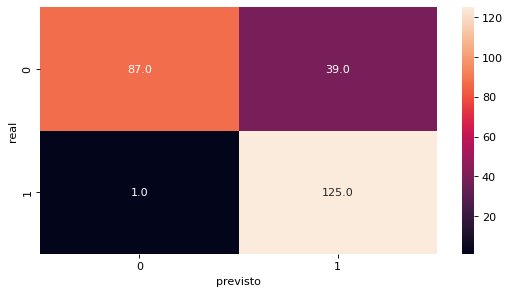

In [89]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_svc), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

### Resultados RandomForestClassifier

In [93]:
modelo_final_Random = RandomForestClassifier(class_weight= 'balanced', criterion= 'gini', max_depth= 11,
                                            min_samples_leaf= 1, min_samples_split= 14, n_estimators= 100)

modelo_final_Random.fit(X_train, y_train)
previsao_random = modelo_final_Random.predict(X_test)

In [94]:
print('A Acurácia do RandomForest foi de %d%% \n' % (accuracy_score(y_test, previsao_random)*100))
print('A Precisao do RandomForest foi de %d%% \n' % (precision_score(y_test, previsao_random)*100))
print('O Reccal_score do RandomForest foi de %d%% \n' % (recall_score(y_test, previsao_random)*100))
print('O F1-Score do RandomForest foi de %d%%' % (f1_score(y_test, previsao_random)*100))

A Acurácia do RandomForest foi de 84% 

A Precisao do RandomForest foi de 79% 

O Reccal_score do RandomForest foi de 92% 

O F1-Score do RandomForest foi de 85%


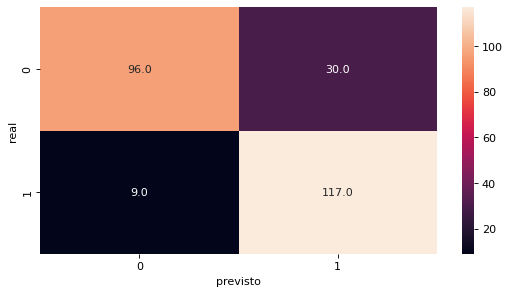

In [96]:
set()
plt.figure(figsize=(8,4), dpi=80)
sns.heatmap(confusion_matrix(y_test, previsao_random), annot=True, fmt='.1f').set(xlabel = 'previsto', ylabel= 'real')
plt.show()

# Conclusão

Em nosso caso, as métricas mais relevantes são a Acurácia e a Revocação. A primeira mede o nível geral de acerto nas classificações e o segundo reduz ao máximo a possibilidade de Falsos Negativos.

Caso hajam muitos "falsos positivos", o algoritmo concederá crédito a clientes inaptos, o que pode gerar perda de dinheiro devido ao alto risco. E quando o algoritmo tiver muitos falsos negativos, pode perder boas oportunidades de gerar crédito para bons pagadores. Por esse motivo o ideal é manter os dois níveis baixos. E esse equilibrio pode ser mensurado pela métrica F1_Score.

Tanto na acurácia, quanto revocação e F1_score o SVC se saiu melhor, reduzindo o número de erros para pessoas que recebem crédito indevido, e classificando corretamente maior número de pessoas que não deveriam receber a liberação do valor.

Por essas razões, é recomendado o uso do SVC para inicio dos testes na empresa ( Acurácia 84% | Reccal_score 99% )